In [13]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import missingno as msno
from scipy.stats import ks_2samp
import yaml
import shap
import random
from lightgbm import LGBMClassifier

from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve, auc, f1_score
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

import plotly.express as px
import plotly
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import utils

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Color Palette

In [14]:
COLOR_FEMALE = '#66c2a5'
COLOR_MALE = '#fc8d62'
COLOR_OTHER = '#808080'
colors = [COLOR_FEMALE, COLOR_MALE, COLOR_OTHER]

palette = sns.color_palette(colors, 3)
palette

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5019607843137255, 0.5019607843137255, 0.5019607843137255)]

## Loading Data

In [15]:
df = utils.load_data()
questions = utils.load_questions()
df.head()

E1  E2  E3  E4  E5  E6  E7  E8  E9  E10  ...  S56  S57  S58  S59  S60  EQ  \
0   3   1   3   2   4   3   1   3   1    3  ...    2    1    4    4    3  37   
1   4   3   3   2   2   2   2   3   4    4  ...    4    4    3    4    2  54   
2   3   3   3   1   1   2   2   2   3    1  ...    3    4    3    2    4  57   
3   2   2   2   1   2   1   3   2   4    4  ...    2    3    3    4    1  43   
4   3   1   2   4   4   2   3   3   2    3  ...    2    1    3    4    1  26   

   SQ  accuracy  gender  age  
0  49        80       1   39  
1  14        98       2   21  
2  12        95       2   32  
3  32        80       2   53  
4  57        97       1   17  

[5 rows x 125 columns]

In [16]:
questions.sample(20)

S51    When I'm in a plane, I do not think about the ...
E30    People often tell me that I am very unpredicta...
E8     I find it hard to know what to do in a social ...
E44    I can sense if I am intruding, even if the oth...
E28    If anyone asked me if I liked their haircut, I...
E19    I can pick up quickly if someone says one thin...
E52    I can tune into how someone else feels rapidly...
S30    When I learn a language, I become intrigued by...
S53    When I am walking in the country, I am curious...
S16    I am bad about keeping in touch with old friends.
S3     I often make resolutions, but find it hard to ...
E41    I can easily tell if someone else is intereste...
E35      I don?tend to find social situations confusing.
E53                          I don't like to take risks.
S15    In maths, I am intrigued by the rules and patt...
E13      I would never break a law, no matter how minor.
E6                I really enjoy caring for other people
S57    I am not interested in u

# Preprocessing

Columns description

**age** "What is your age?", entered as text

**gender** 1=Male, 2=Female, 3=Other

**accuracy** How sure are you of your response?

In [17]:
df.gender = df.gender.map({1: 'Male', 2: 'Female', 3: 'Other'})

# removing impossble values, such as negative and higher than a normal human life span
df.age = df.age.clip(12, 80)

df.drop(['EQ', 'SQ'], axis=1, inplace=True)

In [5]:
# defining gender columns and converting to int
QUESTION_COLS = [col for col in df.columns if col.startswith(('E', 'S'))]
NON_QUESTION_COLS = [col for col in df.columns if col not in QUESTION_COLS]

df[QUESTION_COLS] = df[QUESTION_COLS].astype(int)

In [19]:
# remove respondents with no gender specified
no_gender_specified_pct = np.round(df[df.gender.isnull()].shape[0] / df.shape[0] * 100,2)
print(f'Persons with no gender specified: {no_gender_specified_pct}%')
df = df[df.gender.notnull()]

Persons with no gender specified: 0.21


In [20]:
# Mappping answers to a description
# we are treating strongly agree/disagree same as agree/disagree, respectively
for col in QUESTION_COLS:
    df[col] = df[col].map({0: 'No Answer', 1: 'Disagree', 2: 'Disagree', 3: 'Agree', 4: 'Agree'}).astype("category")

## Age

<AxesSubplot:ylabel='gender'>

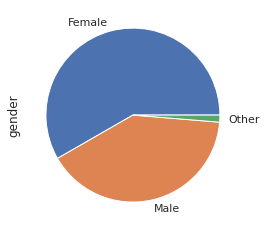

In [23]:
(df.gender.value_counts() / df.shape[0] * 100).round(1).plot.pie()

In [34]:
pd.cut(df.age, bins=[df.age.min(), 18,24,30,35,45,65,80]).value_counts() / df.shape[0]

(18, 24]    0.296341
(12, 18]    0.255216
(24, 30]    0.153311
(35, 45]    0.108633
(45, 65]    0.095026
(30, 35]    0.080965
(65, 80]    0.005972
Name: age, dtype: float64

25% are 18 or younger
30% percent are 18-24
15% are 24-30
8% are 30-35
11% are 35-45
9.5% are 45-65
0.5% are 65+

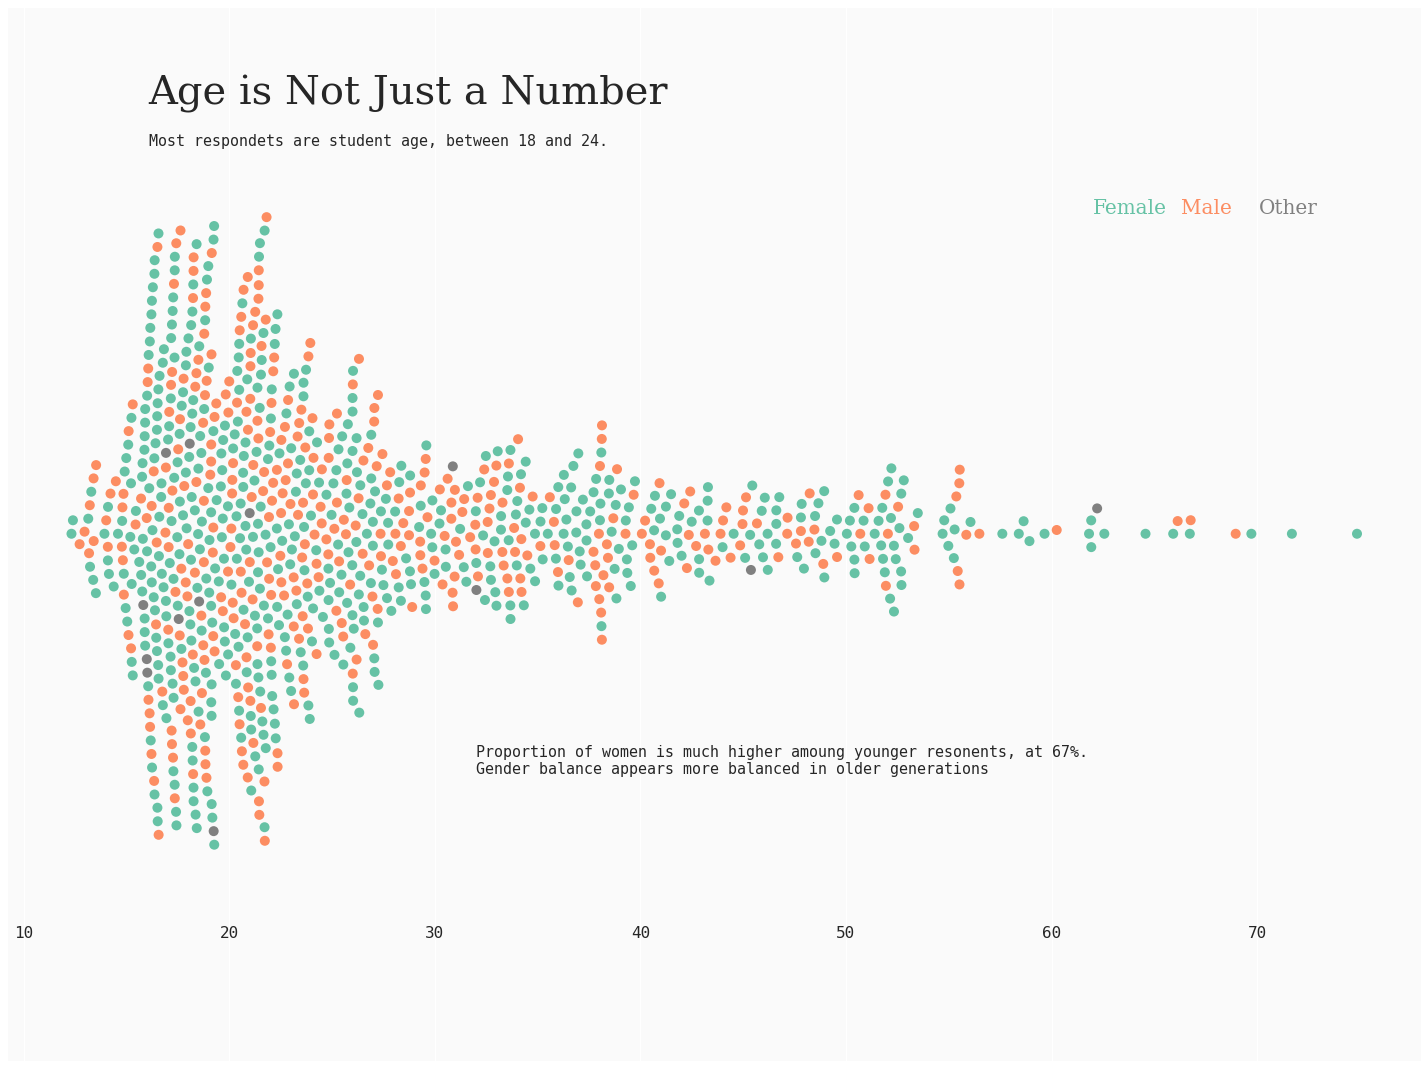

In [26]:
SAMPLE_SIZE = 1000

# add some tiny noisiness for better visualization
df['age_noisy'] = df.age.apply(lambda x: x + random.uniform(0, 1))


fig, ax = plt.subplots(1,1, figsize=(20,15))
ax.set_facecolor('#fafafa')
sns.swarmplot(x='age_noisy', y=['']*SAMPLE_SIZE, 
              hue='gender', data=df.sample(SAMPLE_SIZE),
              dodge=False, size=10, ax=ax,
             palette=palette)

ax.annotate('Age is Not Just a Number', xy=(50, 0),  xycoords='data',
            xytext=(0.1, 0.9), textcoords='axes fraction',
            horizontalalignment='left', verticalalignment='bottom',
            fontsize=40, fontfamily='serif'
            )
ax.annotate('Most respondets are student age, between 18 and 24.', xy=(50, 0),  xycoords='data',
            xytext=(0.1, 0.88), textcoords='axes fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=15, fontfamily='monospace'
            )
ax.annotate('Proportion of women is much higher amoung those 25 or younger, at 67%.\nHowever, gender distribitions appears more balanced in older generations', xy=(50, 0),  xycoords='data',
            xytext=(32, 0.2),
            horizontalalignment='left', verticalalignment='top',
            fontsize=15, fontfamily='monospace'
            )

# legend
ax.annotate('Male', xy=(50, 0),  xycoords='data',
            xytext=(0.83, 0.8), textcoords='axes fraction',
            horizontalalignment='left', verticalalignment='bottom',
            fontsize=20, fontfamily='serif', color=COLOR_MALE
            )
ax.annotate('Female', xy=(50, 0),  xycoords='data',
            xytext=(0.82, 0.8), textcoords='axes fraction',
            horizontalalignment='right', verticalalignment='bottom',
            fontsize=20, fontfamily='serif', color=COLOR_FEMALE
            )
ax.annotate('Other', xy=(50, 0),  xycoords='data',
            xytext=(0.885, 0.8), textcoords='axes fraction',
            horizontalalignment='left', verticalalignment='bottom',
            fontsize=20, fontfamily='serif', color=COLOR_OTHER
            )

ax.set_xlabel('')
ax.get_legend().remove()
ax.tick_params(axis="x",direction="in", pad=-135)
plt.xticks(fontsize=16, fontfamily='monospace')
plt.tight_layout()
plt.savefig('../figures/age_distr.png')
#ax.set_xticks([])


# EDA

In [35]:
sns.set(rc={'axes.facecolor':'#fafafa', 'figure.facecolor':'#fafafa'})

/tmp/ipykernel_222/1383291874.py:29: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



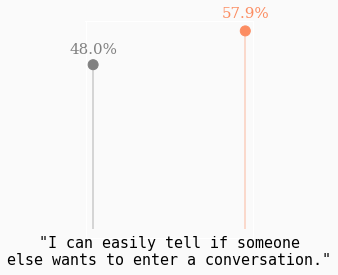

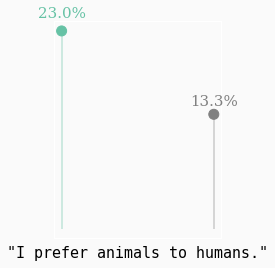

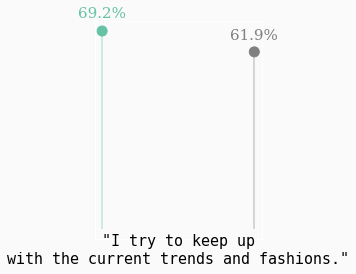

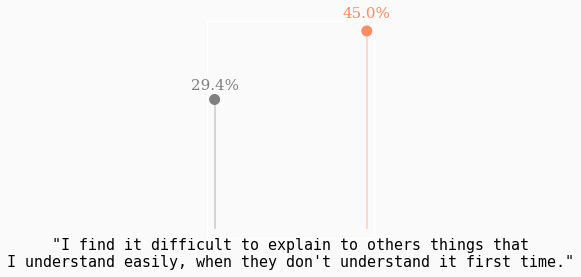

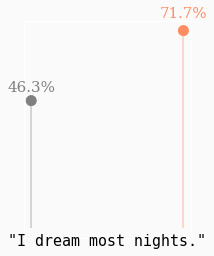

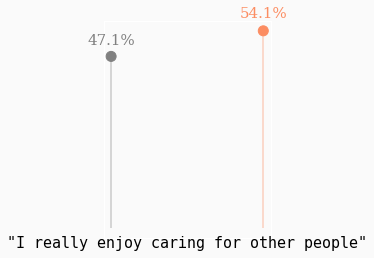

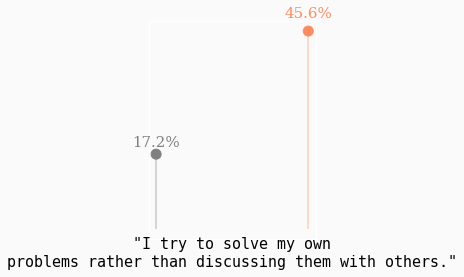

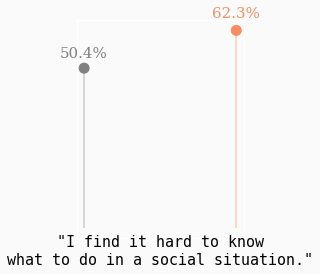

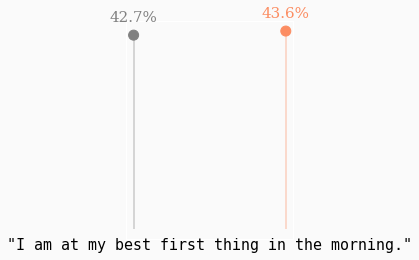

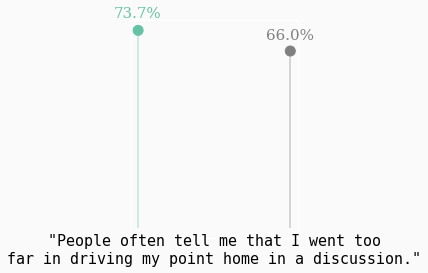

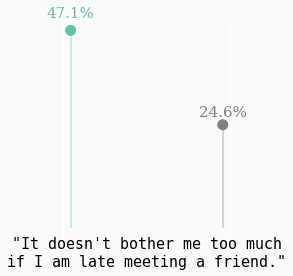

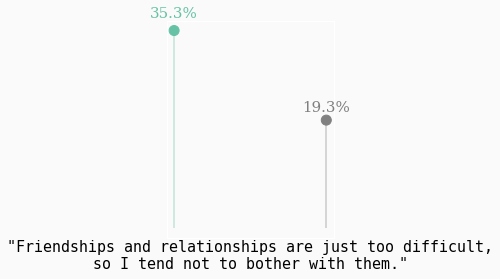

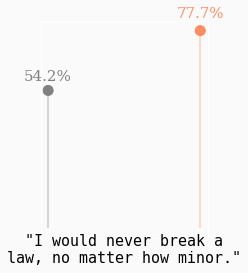

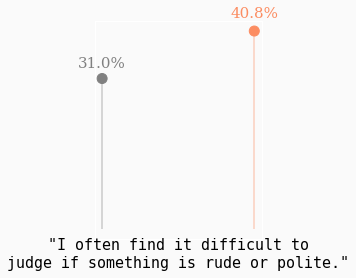

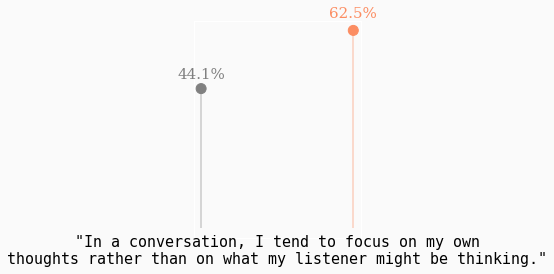

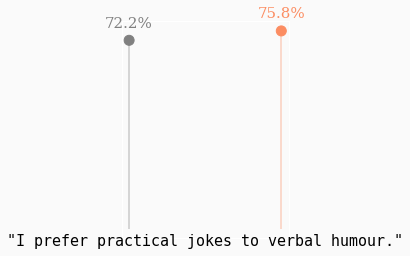

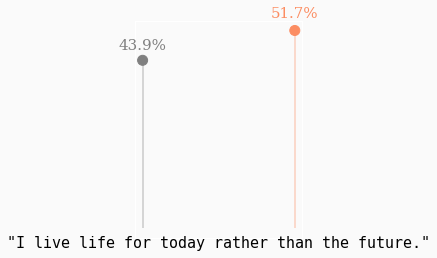

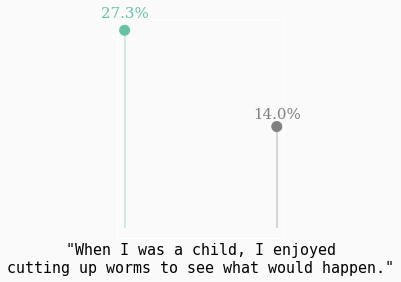

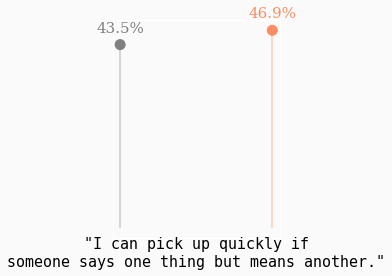

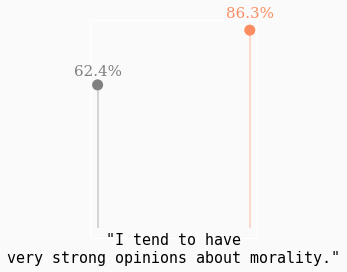

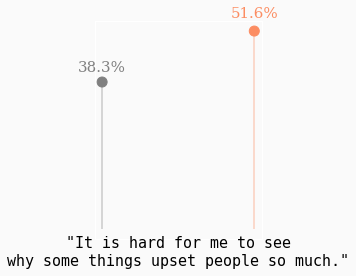

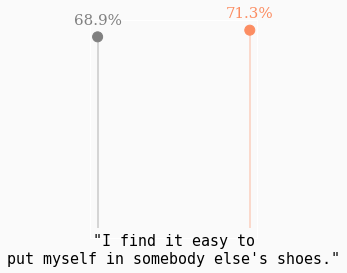

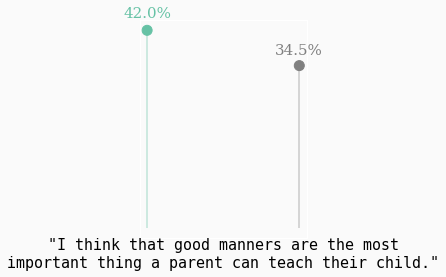

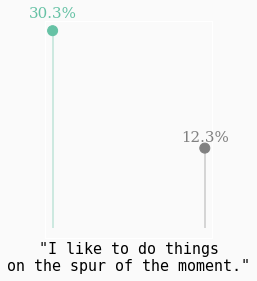

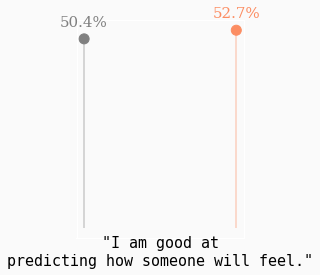

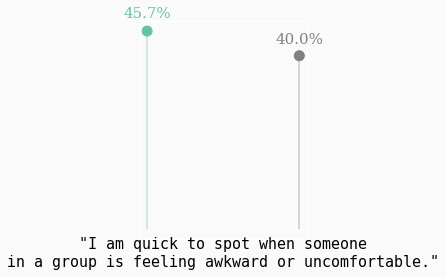

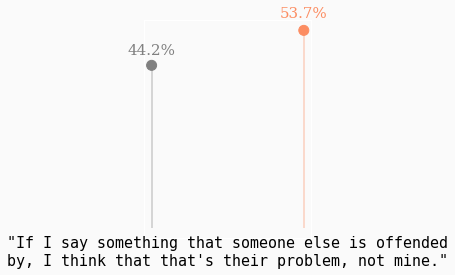

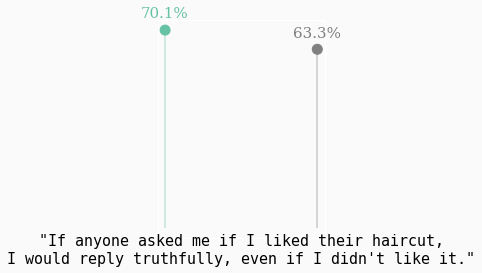

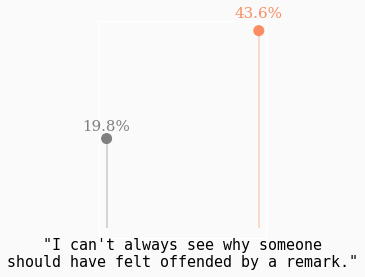

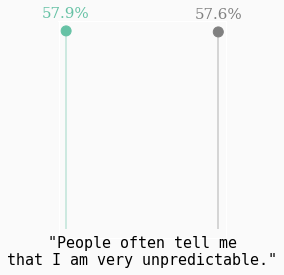

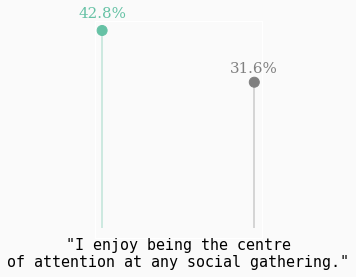

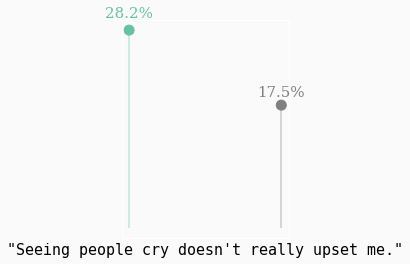

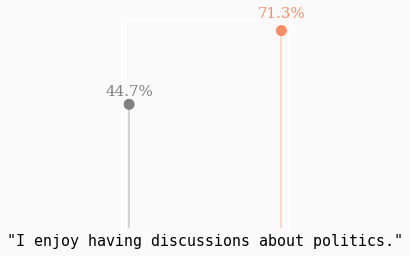

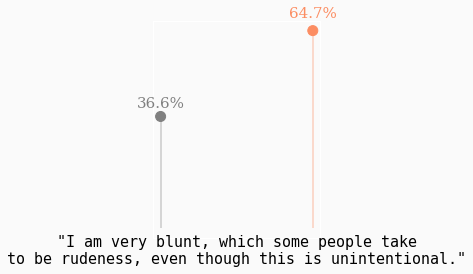

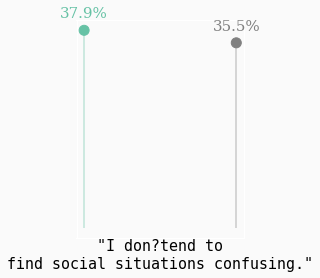

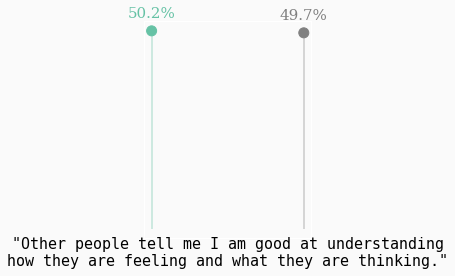

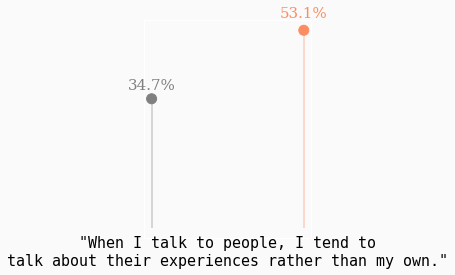

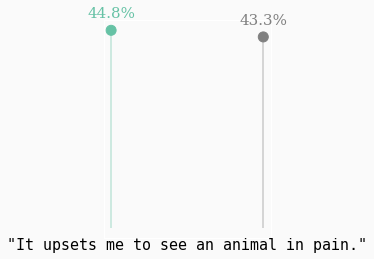

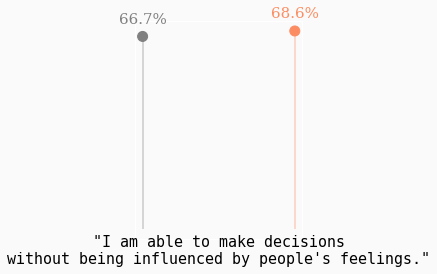

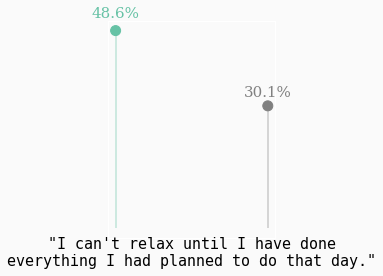

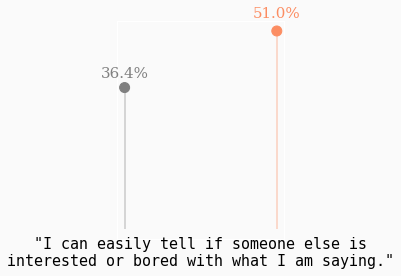

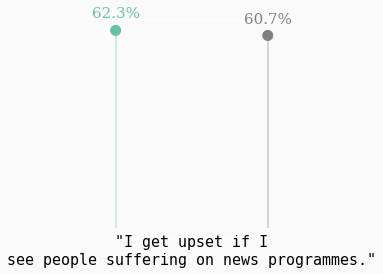

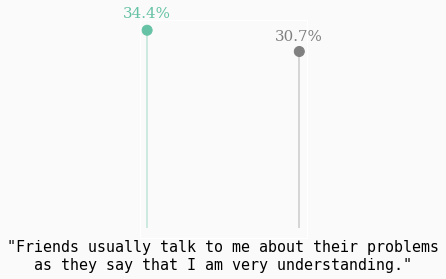

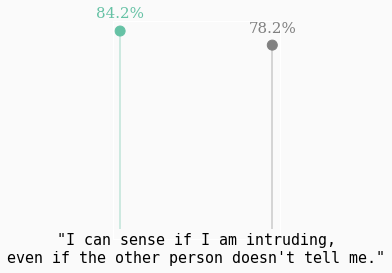

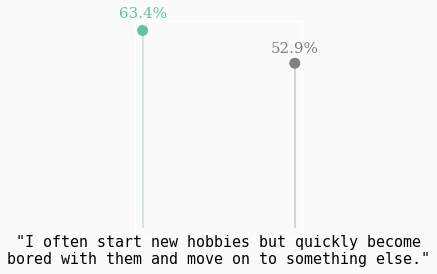

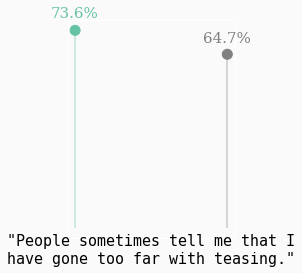

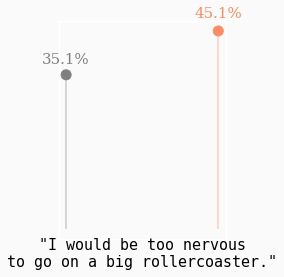

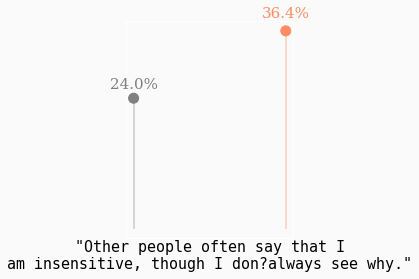

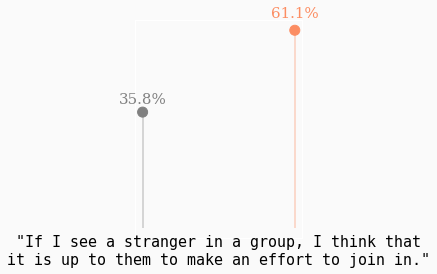

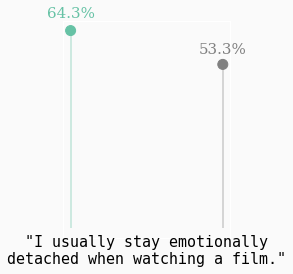

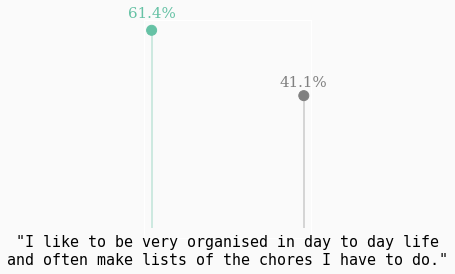

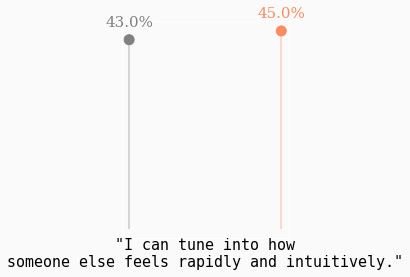

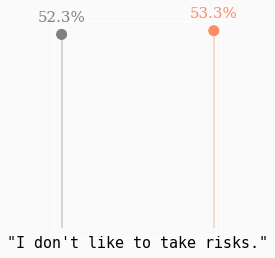

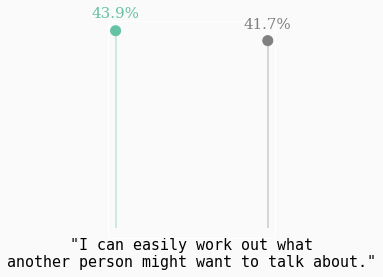

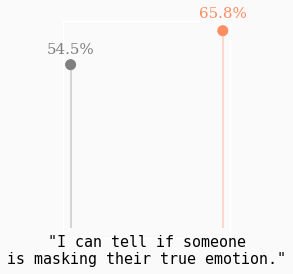

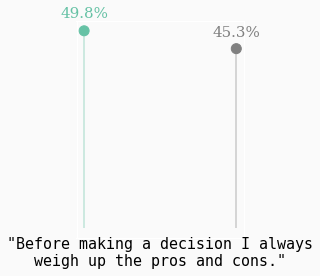

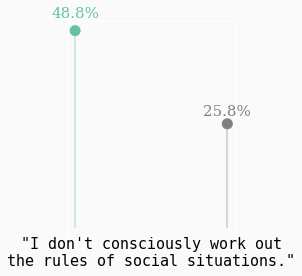

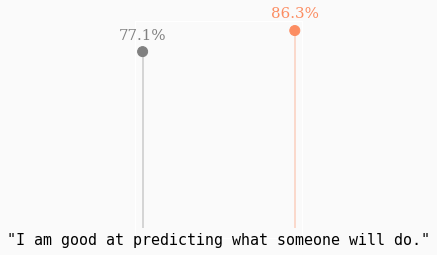

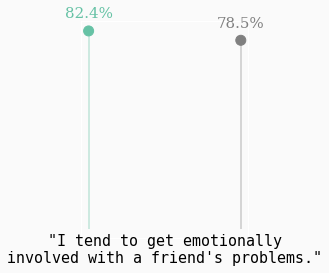

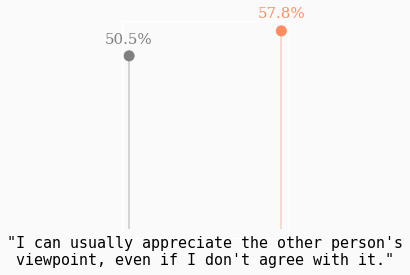

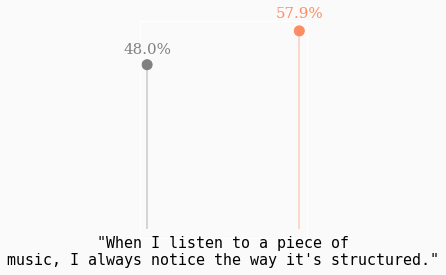

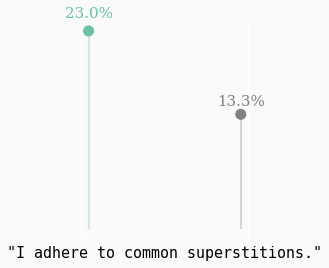

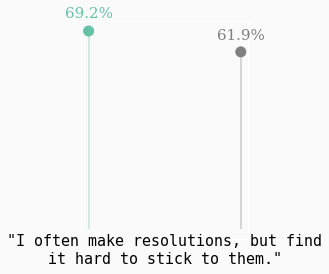

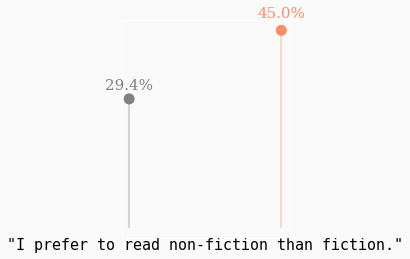

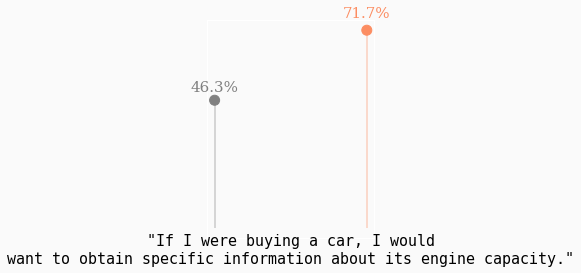

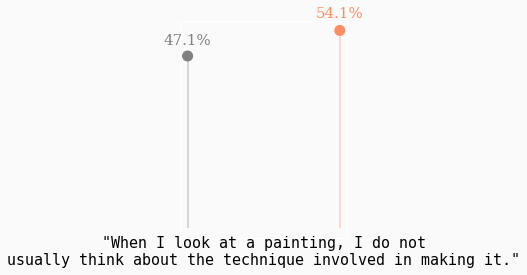

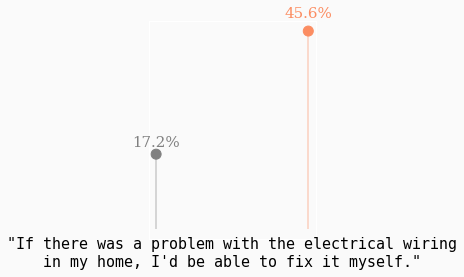

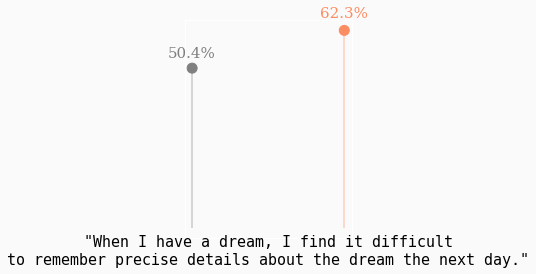

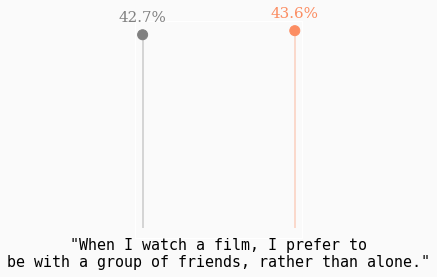

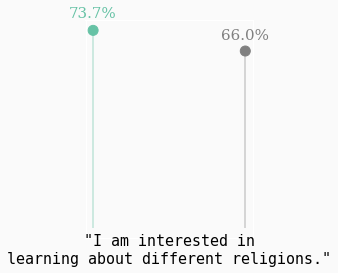

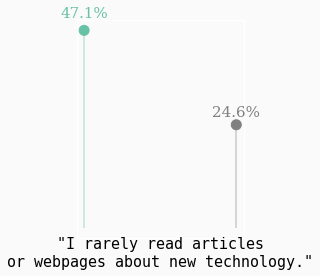

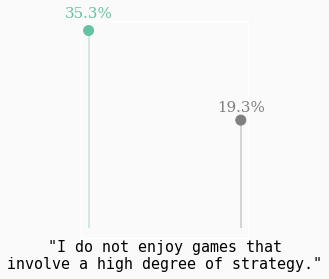

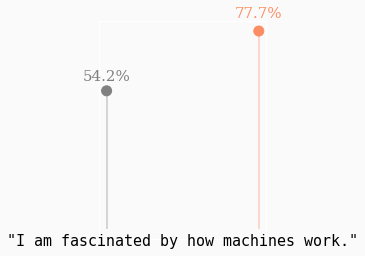

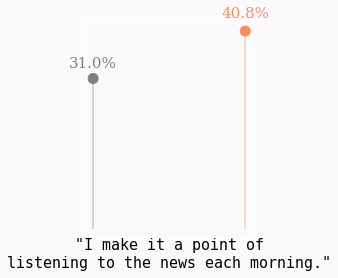

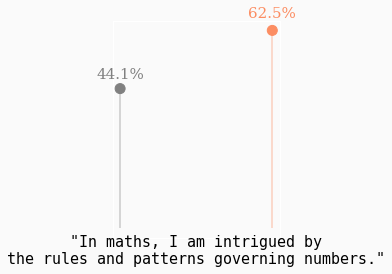

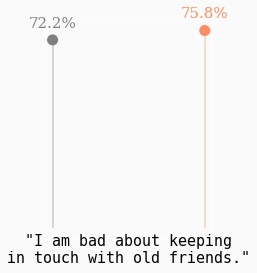

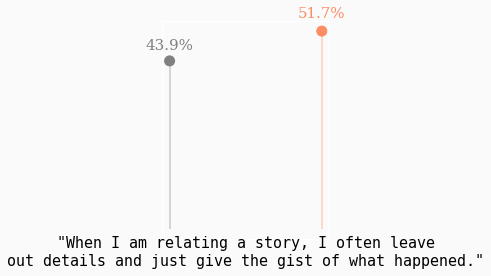

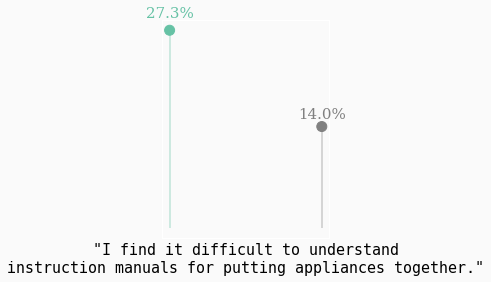

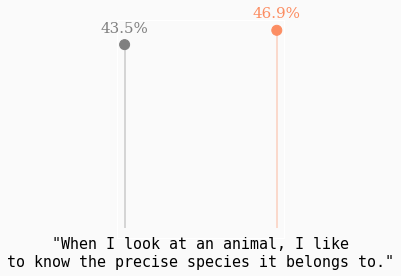

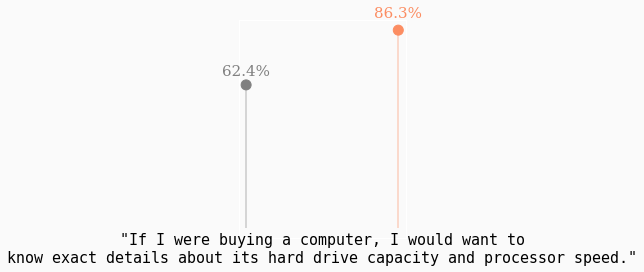

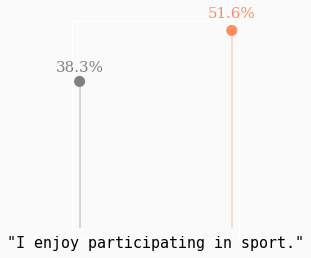

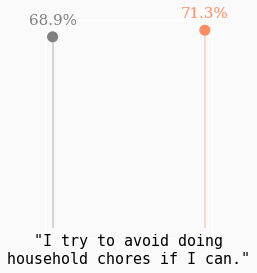

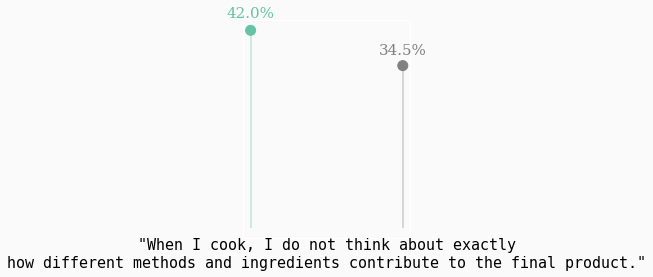

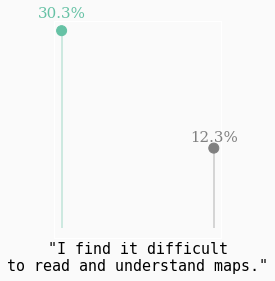

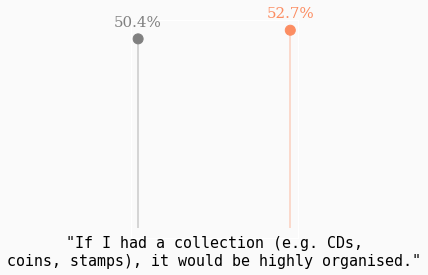

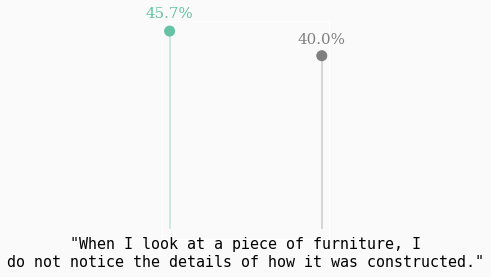

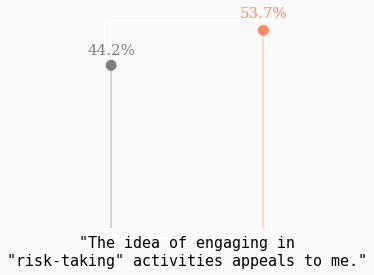

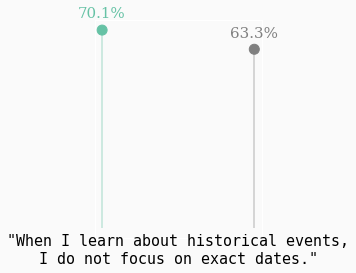

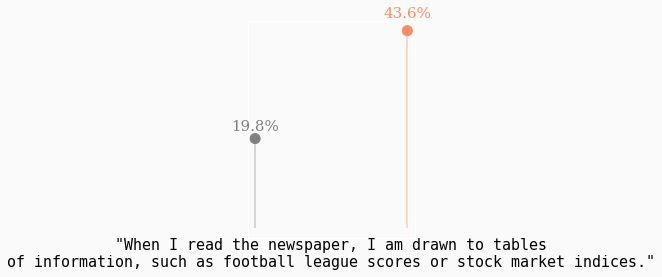

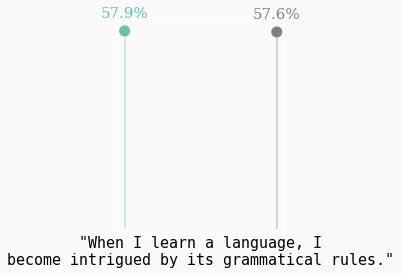

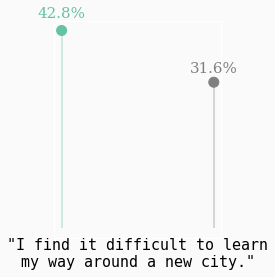

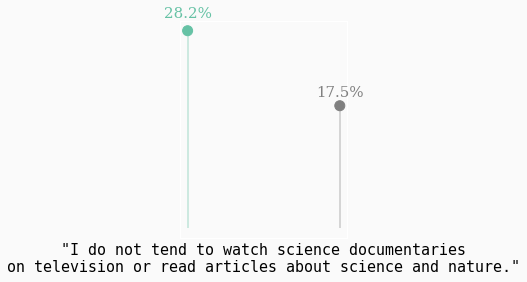

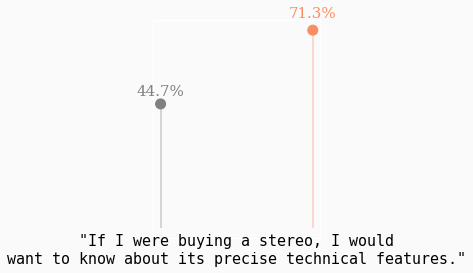

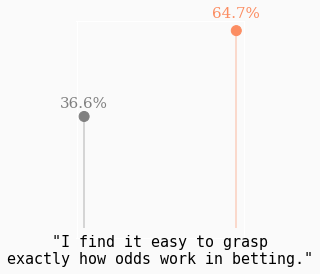

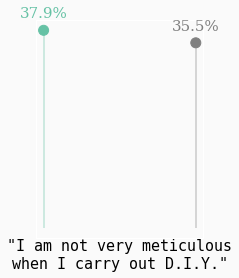

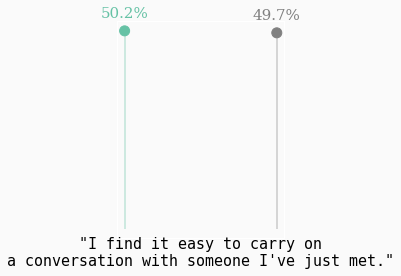

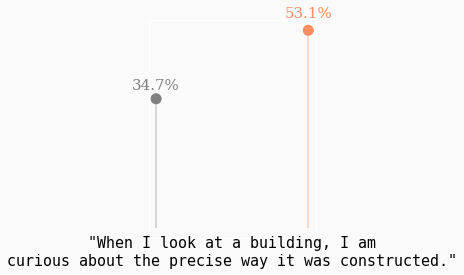

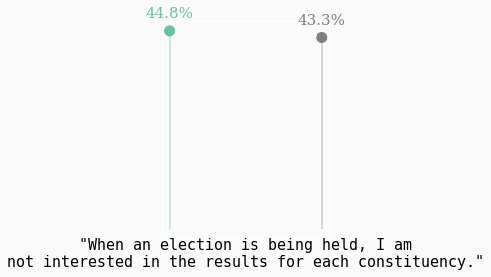

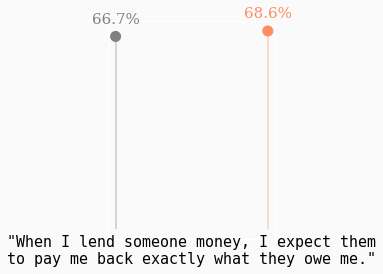

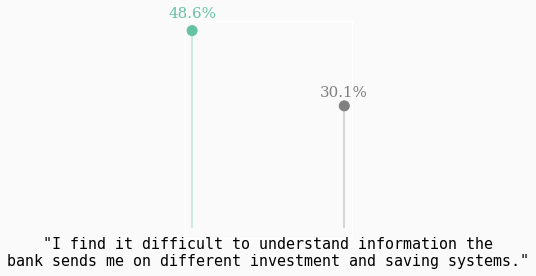

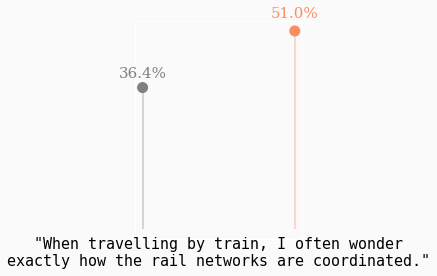

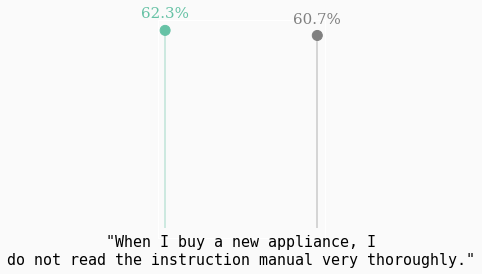

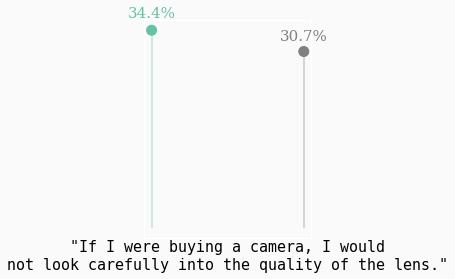

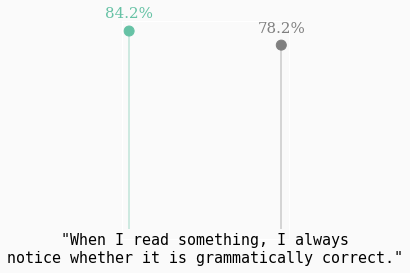

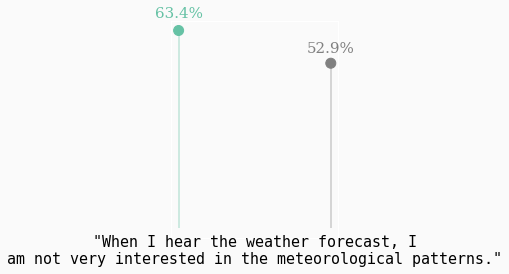

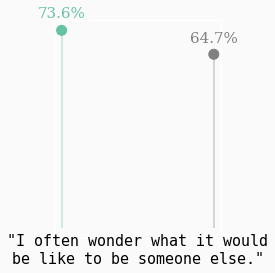

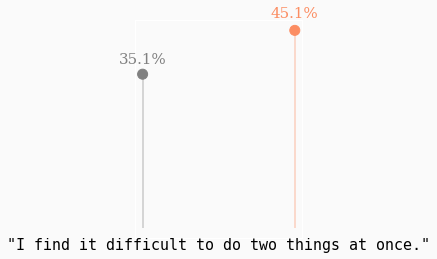

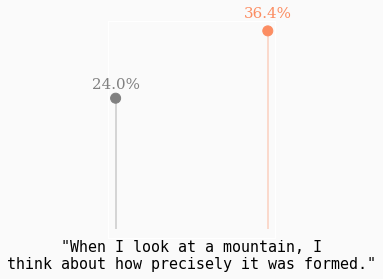

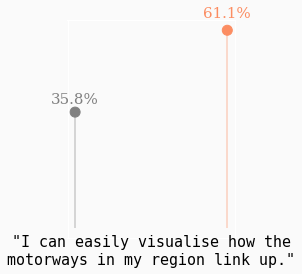

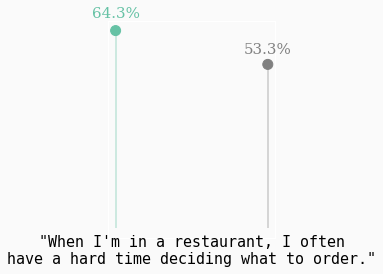

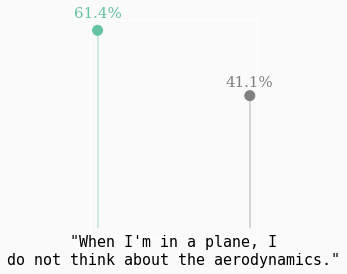

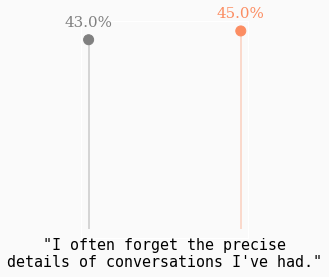

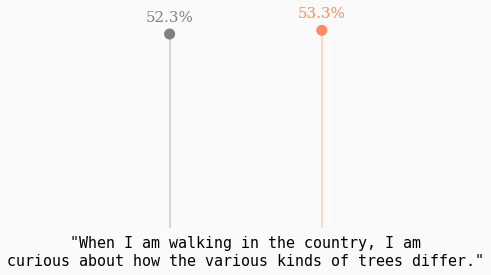

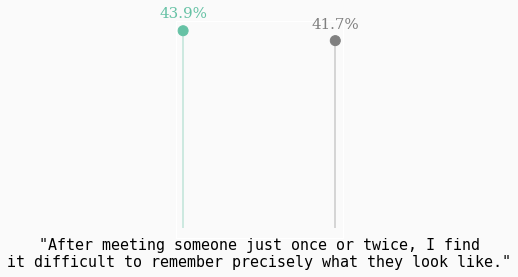

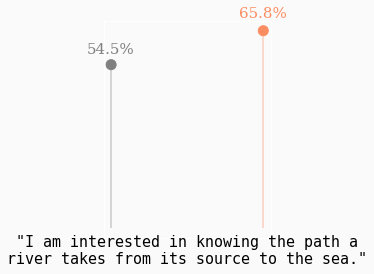

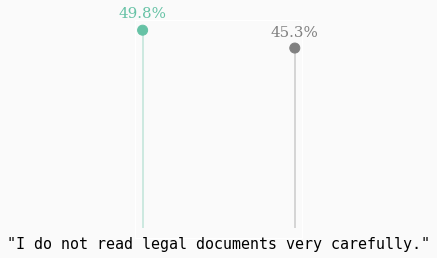

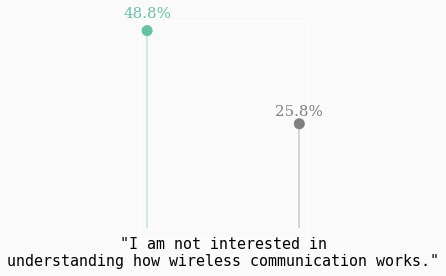

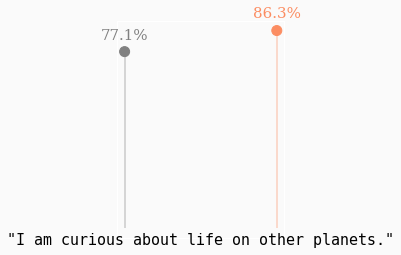

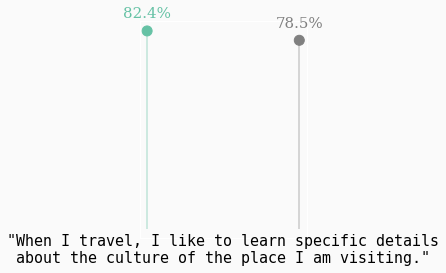

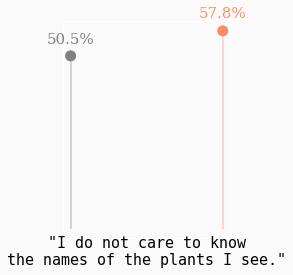

In [209]:
data_no_other_gender = df.query('gender != "Other"')
questions_dict = utils.load_questions('eqsq', False)
DUAL_PALETTE = sns.color_palette([COLOR_FEMALE, COLOR_MALE], 2)

def flatten(t):
    return [item for sublist in t for item in sublist]

def format_title(title):
    if len(title) > 45:
        words = title.split(' ')
        breakpoint = int(len(words)/2)
        part1 = words[:breakpoint]
        part2 = words[breakpoint:]
        new_title = (' ').join(part1) + '\n' + (' ').join(part2)
        return new_title
    return title
        

def plot_question(question, ax, data):
    gender_answer = data.groupby(['gender', question]).count().age.unstack()
    pct_agree = (gender_answer.divide(gender_answer.sum(1), axis=0)* 100).round(1).Agree
    my_range=range(1,len(pct_agree.index)+1)
    
    fem_color = 'grey' if pct_agree.loc['Female'] < pct_agree.loc['Male'] else COLOR_FEMALE
    male_color = 'grey' if pct_agree.loc['Male'] < pct_agree.loc['Female'] else COLOR_MALE
    my_color = [fem_color, male_color]
    
    if ax is None:
        fig, ax= plt.subplots(1,1,figsize=(3,4))

    ax.vlines(x=my_range, ymin=0, ymax=pct_agree/2, color=my_color, alpha=0.4)
    plt.scatter(my_range, pct_agree/2, color=my_color, alpha=1, s=100)

    fem_coord = (1, pct_agree.loc['Female']/2*1.05)
    ax.annotate(str(pct_agree.loc['Female'])+'%',
                xy=fem_coord, xytext=fem_coord,
                horizontalalignment='center', verticalalignment='bottom',
                fontsize=15, fontfamily='serif', color=fem_color
                )

    male_coord = (2,pct_agree.loc['Male']/2*1.05)
    ax.annotate(str(pct_agree.loc['Male'])+'%',
                xy=male_coord, xytext=male_coord,
                horizontalalignment='center', verticalalignment='bottom',
                fontsize=15, fontfamily='serif', color=male_color
                )
    
    ax.annotate(f'"{format_title(questions_dict[question])}"',
                xy=(1.5,10), xytext=(1.5,-1),
                horizontalalignment='center', verticalalignment='top',
                fontsize=15, fontfamily='monospace', color='black'
                )
    ax.set_xticks([])
    ax.set_yticks([])
    #ax.set_title(f'"{format_title(questions_dict[question])}"', fontsize=12, fontfamily='monospace')
    return 

for question in questions_dict:
    plot_question(question, None, df[df.gender != 'Other'])

## Dot Plot

In [151]:
import itertools

In [152]:
data = pd.DataFrame(list(itertools.product(list(range(10)), list(range(10))[::-1])))
data.columns = ['x', 'y']
data = data.sort_values(by=['y', 'x'])
data['size'] = 3
data['color'] = 'disagree'
data['gender'] = 'woman'
data.iloc[:15]['color'] = 'agree'
data.iloc[:15]['gender'] = 'man'


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [153]:
import plotly.io as pio

fig = px.scatter(data, x="x", y="y", size='size', color='color')
fig.update_layout(template='simple_white', title="49 in 100 men find it difficult to explain their thoughts")

fig.update_layout(
    font_family="Courier New",
    font_color="darkgrey",
    title_font_family="Courier New",
    title_font_color="black",
    font=dict(
        family="Courier New, serif",
        size=15,
    ),
    xaxis = dict(
        tickvals = [],
        ticktext = []
    ),
    yaxis = dict(
        tickvals = [],
        ticktext = []
    ),
)
fig.update_xaxes(showline=True, linewidth=2, linecolor='#fafafa', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='#fafafa', mirror=True)
fig.update_layout(showlegend=False)

fig

E47: I would be too nervous to go on a big rollercoaster.
E4: I find it difficult to explain to others things that I understand easily, when they don't understand it first time.
E29: I can't always see why someone should have felt offended by a remark.
E60: I can usually appreciate the other person's viewpoint, even if I don't agree with it.
E20: I tend to have very strong opinions about morality.
E7: I try to solve my own problems rather than discussing them with others.
E44: I can sense if I am intruding, even if the other person doesn't tell me.
E8: I find it hard to know what to do in a social situation.
E54: I can easily work out what another person might want to talk about.
E2: I prefer animals to humans.

# Modelling: Predicting gender

In [210]:
data = df.copy()

In [456]:
data['is_female'] = (data.gender == 'Female').astype(int)
data = data.drop(['gender', 'age_noisy'], axis=1)

In [457]:
data.is_female.sum() / data.shape[0]

0.5908045977011495

In [458]:
len(data.columns) - 1

121

In [459]:
Y_LABEL= 'is_female'
temp1 = data[[*QUESTION_COLS, 'is_female']]#.iloc[:100000]

y = temp1[Y_LABEL]
X = temp1.drop(Y_LABEL, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [460]:
lgbm = LGBMClassifier(max_depth=10, colsample_bytree=0.7)
rf = RandomForestClassifier(max_depth=10)

models = [lgbm]

In [461]:
for model in tqdm(models):
    model.fit(X_train, y_train)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.56it/s]


In [462]:
results = pd.DataFrame({'actuals': y_test})
metrics = dict()

for model in tqdm(models):
    preds = model.predict(X_test)
    results[f'preds_{model.__class__.__name__}'] = model.predict_proba(X_test)[:, 1]
    metrics[model.__class__.__name__] = dict()
    for metric in [precision_score, recall_score, roc_auc_score, accuracy_score]:
        metrics[model.__class__.__name__][metric.__name__] = metric(results.actuals, preds)
        
metrics = pd.DataFrame(metrics).T
metrics

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.98it/s]


accuracy_score  precision_score  recall_score  roc_auc_score
LGBMClassifier         0.75249         0.771515      0.825551       0.736277

<AxesSubplot:>

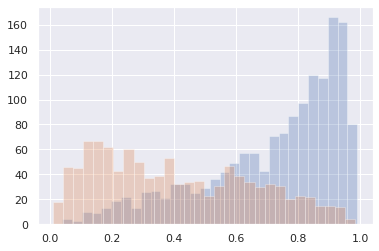

In [463]:
results.query('actuals == 1').preds_LGBMClassifier.hist(bins=30, alpha=0.3)
results.query('actuals == 0').preds_LGBMClassifier.hist(bins=30, alpha=0.3)

[]

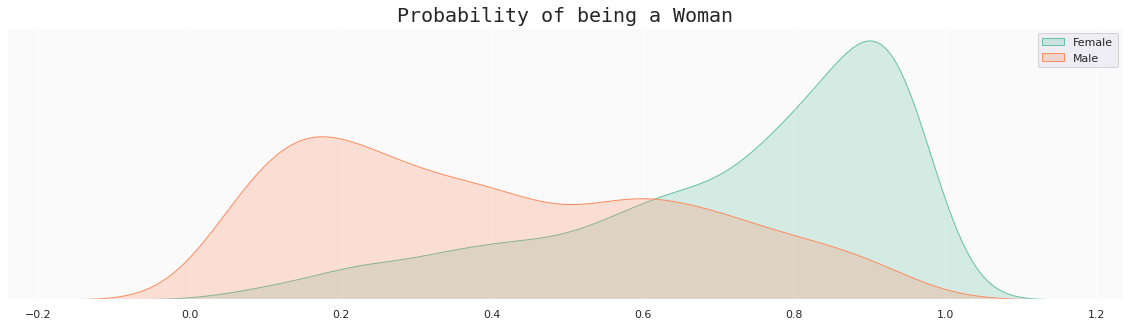

In [464]:
data_women = results.query('actuals == 1').preds_LGBMClassifier
data_men = results.query('actuals == 0').preds_LGBMClassifier

fig, ax = plt.subplots(1, 1, figsize=(20,5))
ax.set_facecolor('#fafafa')
sns.kdeplot(data_women, fill=True, label='Female', ax=ax, color=COLOR_FEMALE)
sns.kdeplot(data_men, fill=True, label='Male', ax=ax, color=COLOR_MALE)

plt.legend()
plt.title('Probability of being a Woman',
          fontfamily='monospace',
          fontsize=20)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticks([])

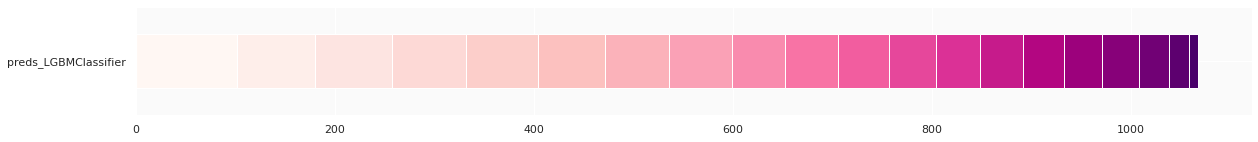

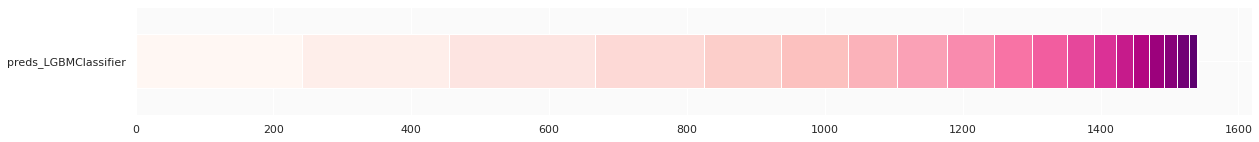

In [422]:
data = pd.DataFrame(pd.cut(results.query('actuals == 0').preds_LGBMClassifier, 20).value_counts()).T

fig, ax = plt.subplots(1, 1, figsize=(20,2))
ax.set_facecolor('#fafafa')
data.plot.barh(stacked=True, cmap = 'RdPu', ax=ax)
ax.get_legend().remove()

data = pd.DataFrame(pd.cut(results.query('actuals == 1').preds_LGBMClassifier, 20).value_counts()).T

fig, ax = plt.subplots(1, 1, figsize=(20,2))
ax.set_facecolor('#fafafa')
data.plot.barh(stacked=True, cmap = 'RdPu', ax=ax)
ax.get_legend().remove()

In [423]:
results = results.join(df['age'], how='left')

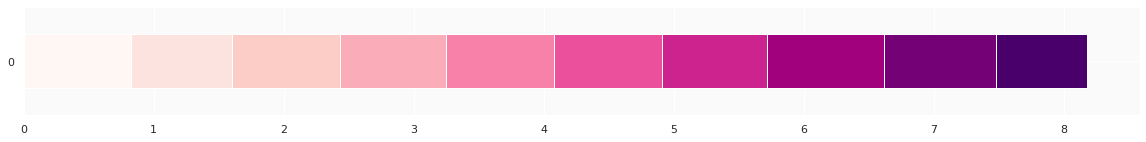

In [424]:
results['age_bin'] = pd.DataFrame(pd.cut(results.age, 10))
age_accuracy = pd.DataFrame(results.groupby('age_bin')\
    .apply(lambda gr: f1_score(gr.actuals, (gr.preds_LGBMClassifier >= 0.5).astype(int)))).T

fig, ax = plt.subplots(1, 1, figsize=(20,2))
ax.set_facecolor('#fafafa')
age_accuracy.plot.barh(stacked=True, cmap = 'RdPu', ax=ax)
ax.get_legend().remove()

In [425]:
age_accuracy

age_bin  (11.942, 17.8]  (17.8, 23.6]  (23.6, 29.4]  (29.4, 35.2]  \
0              0.822458      0.781163      0.826087      0.822785   

age_bin  (35.2, 41.0]  (41.0, 46.8]  (46.8, 52.6]  (52.6, 58.4]  (58.4, 64.2]  \
0            0.823529      0.835616      0.806452      0.896552      0.862069   

age_bin  (64.2, 70.0]  
0                 0.7

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.841


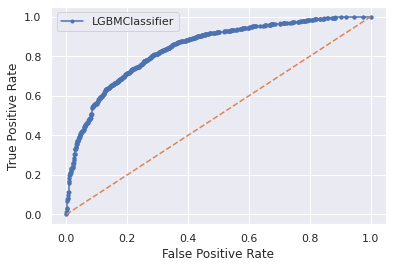

In [426]:
ns_probs = [0 for _ in range(len(y_test))]

# calculate scores
for model in models:
    probs = model.predict_proba(X_test)[:, 1]
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, probs)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Logistic: ROC AUC=%.3f' % (lr_auc))
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, probs)
    plt.plot(lr_fpr, lr_tpr, marker='.', label=model.__class__.__name__)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.show()

In [465]:
results = results.join(X_test)

In [466]:
results['low_prob_female'] = results.preds_LGBMClassifier < 0.5

/tmp/ipykernel_20/3840653851.py:1: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



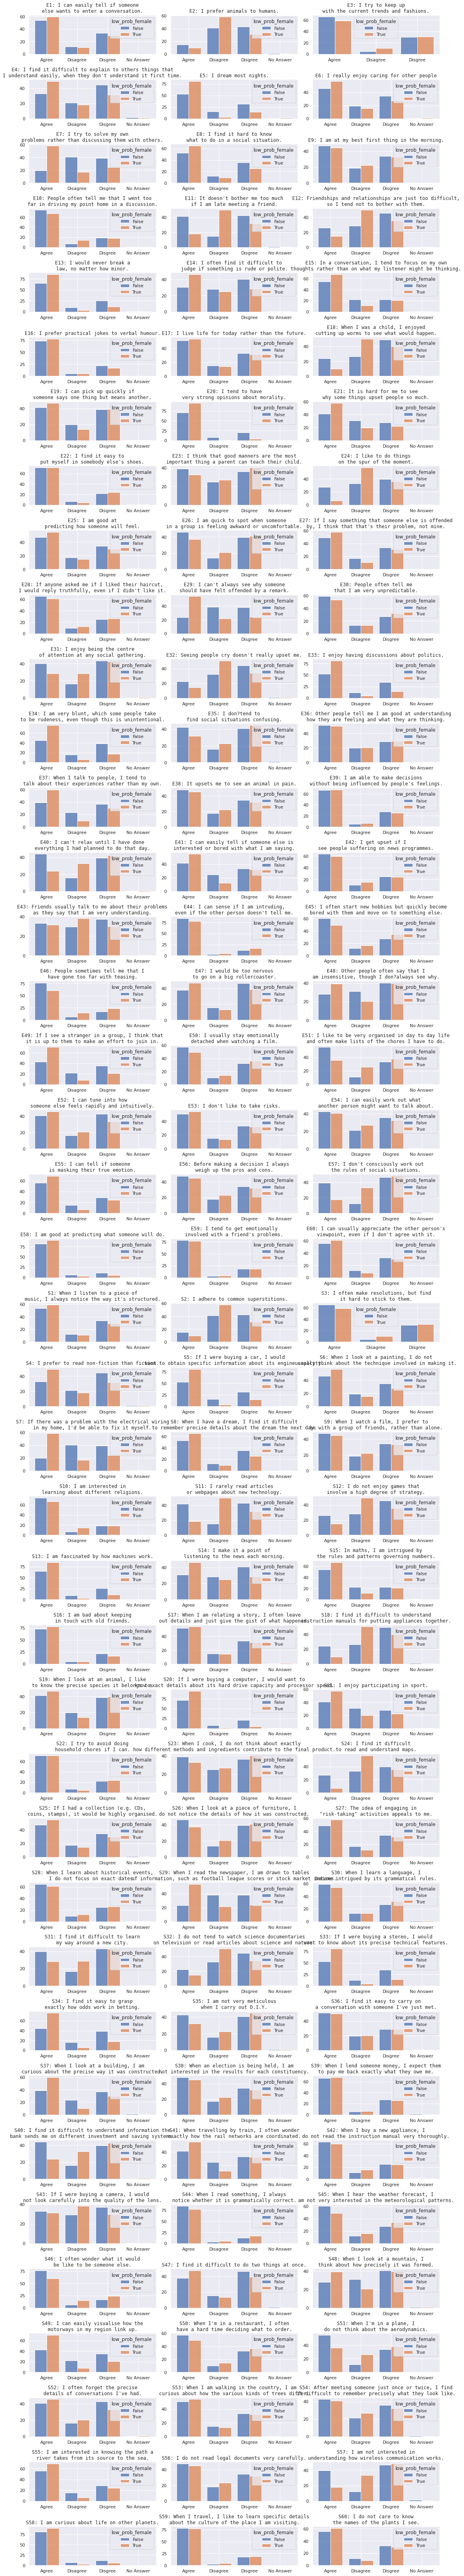

In [429]:
num_plots = len(questions_dict)
n_cols = 3
n_rows = int(np.ceil((num_plots / n_cols)))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15,90))
fig.patch.set_facecolor('white')
for question, ax in zip(questions_dict, flatten(axs)):
    plot_question(question, ax, results.query('(actuals == 0)'), hue='low_prob_female')
plt.tight_layout()

## Feature Importances

In [430]:
shap.initjs()

In [431]:
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X)

/home/jumbo/.cache/pypoetry/virtualenvs/mars-venus-GBjGtfb3-py3.9/lib/python3.9/site-packages/shap/explainers/_tree.py:351: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



In [432]:
shap.force_plot(explainer.expected_value[1], shap_values[1][10,:], X.iloc[10,:],
               plot_cmap=[COLOR_FEMALE, COLOR_MALE])

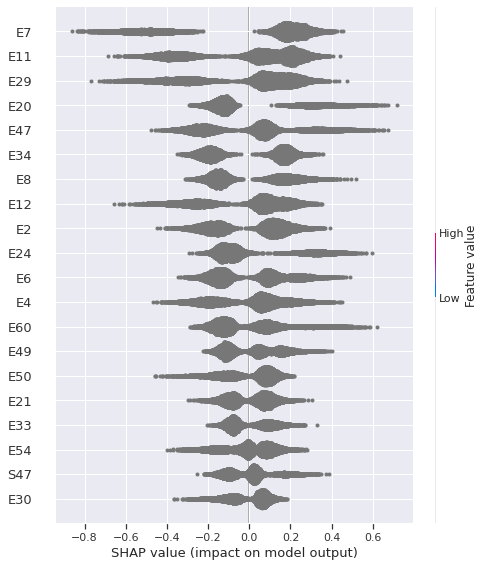

In [473]:
shap.summary_plot(shap_values[1], X, plot_type='dot')

<AxesSubplot:>

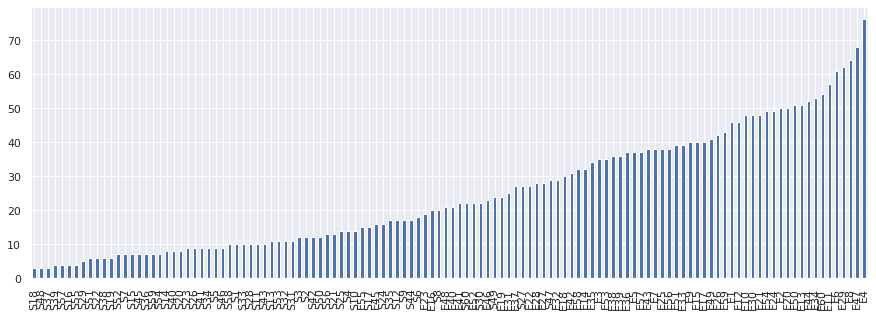

In [467]:
importances = pd.Series(dict(zip(list(X.columns), lgbm.feature_importances_))).sort_values()
importances.plot.bar(figsize=(15,5))

In [468]:
top_questions = importances.tail(20).index[::-1]
for q in top_questions:
    print(f'{q}: {questions_dict[q]}')

E4: I find it difficult to explain to others things that I understand easily, when they don't understand it first time.
E47: I would be too nervous to go on a big rollercoaster.
E8: I find it hard to know what to do in a social situation.
E29: I can't always see why someone should have felt offended by a remark.
E6: I really enjoy caring for other people
E11: It doesn't bother me too much if I am late meeting a friend.
E60: I can usually appreciate the other person's viewpoint, even if I don't agree with it.
E34: I am very blunt, which some people take to be rudeness, even though this is unintentional.
E44: I can sense if I am intruding, even if the other person doesn't tell me.
E13: I would never break a law, no matter how minor.
E50: I usually stay emotionally detached when watching a film.
E20: I tend to have very strong opinions about morality.
E2: I prefer animals to humans.
E24: I like to do things on the spur of the moment.
E54: I can easily work out what another person might wa

In [ ]:
for q in top_questions:
    temp = df.groupby('gender')[q].value_counts().unstack()
    print(q, questions_dict[q], '\n', (temp.divide(temp.sum(1), axis=0) * 100).round(1))